In [6]:
import random
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.ndimage.interpolation import rotate
from scipy import signal
from skimage.transform import resize

import matplotlib.pyplot as plt

In [25]:
"""
This snow mix data augmentation generates synthetic snow masks in the following fashion
1. input gaussian noise map
2. gaussian blur filter
3. threshold
4. motion blur kernel
"""

# SNOW_MIX_PARAMS
SM_MEAN = .5 # mean for gaussian noise
SM_SD = 1 # standard deviation for gaussian noise
SM_GAUSS_SD = 3 # gaussian blur standard deviation
SM_SCALE_ARRAY = [.5, 1, 2, 3, 5] # scale to determine motion blur kernel size

SM_THRESH_RANGE=(.72,.78) # threshold for gaussian noise map
SM_ROTATE_RANGE=60 # rotate range for motion blur kernel
SM_NO_BLUR_FRAC=0 # percent of time with no motion blur

img_size = 1000 # size of input image

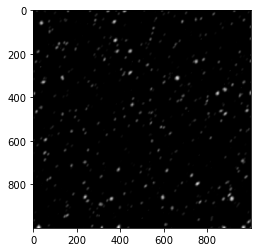

In [27]:
#SNOW MIX
final_mask = np.zeros((img_size, img_size))
threshold = random.uniform(SM_THRESH_RANGE[0], SM_THRESH_RANGE[1])
base_angle = random.uniform(-1 * SM_ROTATE_RANGE, SM_ROTATE_RANGE)
for scale in SM_SCALE_ARRAY:
    # Generate snow layer with gaussian map thresholding
    inv_scale = 1/scale
    layer = np.random.normal(SM_MEAN, SM_SD, (int(img_size*scale), int(img_size*scale)))
    layer = gaussian_filter(layer, sigma=SM_GAUSS_SD)
    layer = layer>threshold
    layer = resize(layer,(img_size,img_size))
    
    # motion blur
    kernel_size = random.randint(10,15)
    angle = base_angle + random.uniform(-30,30) # angle for motion blur
    SM_KERNEL_SIZE = min(max(int(kernel_size*inv_scale),3), 15)
    kernel_v = np.zeros((SM_KERNEL_SIZE, SM_KERNEL_SIZE))
    kernel_v[int((SM_KERNEL_SIZE - 1)/2),:] = np.ones(SM_KERNEL_SIZE)
    kernel_v = rotate(kernel_v, 90-angle)
    if (scale > 4):
        kernel_v = gaussian_filter(kernel_v, sigma=1)
    elif (scale < 1):
        kernel_v = gaussian_filter(kernel_v, sigma=3)
    else:
        kernel_v = gaussian_filter(kernel_v, sigma=int(4-scale))
    kernel_v *= 1/np.sum(kernel_v)
    if random.random() > SM_NO_BLUR_FRAC:
        layer = signal.convolve2d(layer, kernel_v, boundary='symm', mode='same')
    
    # blend with final mask
    final_mask += layer - final_mask * layer

# extend to 3 rgb channel dims
final_mask = np.expand_dims(final_mask, 2)
final_mask = np.tile(final_mask, (1, 1, 3))

# show mask
plt.imshow(final_mask)
plt.show()
# inp_img += final_mask - inp_img * final_mask